# Character Impact Project (Part 6) - Facial Recognition
## OpenCV Facial Recognition
### Alden Chico

---

## Premise

How do we as humans associate the name of a person with their face? Naturally, the first thing we do is look at the other person's face. We focus especially on the other person's eyes, nose shape, face shape, lips, and ears to uniquely identify the person we're looking at as someone we've met in the past. Once we've distinguished these characteristic features, we recall other times we've interacted with the person to link the person's face to their name. After all this, we make our best guess and call out the person's name.

As humans, the more times we see the person's face and interact with them knowing the person's name, the more likely we'll know that person's name the next time we see them. Facial recognition for machine learning works the same way. If you provide the model with many pictures of the same person, the model will be more likely to correctly guess who that person is on a new picture that you provide it.

Conversely, our memory often eludes us. We might guess the name wrong (embarrasing!). We might not remember the person's name even though we know that we've met that person before ("sup dude!"). Or sometimes we might not even get the chance to see the person's face and identify who that person is because our focus was elsewhere.

<figure>
<img src="https://cdn.apsari.com/107673/uploads/d7e55f40-76e6-11e9-a81c-c599db33e986_800_420.png" alt="Baby Office T_T" class="center" style=width:449px;height:300px;>
<figcaption><center><b>Who are these cute office workers?</b></center></figcaption>
</figure> 

The ways that humans identify names to faces and make honest mistakes in this simple classification task are all situations relevant to machine learning methods of facial recognition. <b>Machine vision and facial recognition identify people by mathematically encoding features from faces in a set of test images. Using this model to associate names to faces, the computer can then make predictions on faces of new images based on the features from these test images.</b>

<a href="https://aldenmchico.github.io/Alden-Blog/character_impact/part_5/facial_classifier_comparison"> In the last blog post</a>, we compared two different facial detection methods and compared their average runtimes. We chose to use the Local Binary Pattern Histogram (LBPH) Classifier for the remainder of our project due to its superior runtime efficiency over the Haar Classifier.

For this blog post, we'll do an in-depth exploration on facial recognition in python. The steps we'll perform are:

1. Preparing data for the facial recognition model

2. Creating a custom predict method that uses the facial recognition model to predict characters from <i>The Office</i> in an image.

3. Preparing utility functions that are useful for cross-validating the model.

4. Running a cross-validation on the naive facial recognition model to evaluate performance.

By the end of this blog post, we'll not only showcase OpenCV's LBPH Face Recognizer model on facial images of characters from <i>The Office</i>, but we'll also cross-validate the model to evaluate its performance. Once we know the baseline performance of the model, we'll spend time in the next blog post tweaking the model to get the best possible performance out of the LBPH Face Recognizer. With all that being said, let's begin!

---

## Preparing Data for the Facial Recognition Model

In order to train our facial recognition model to identify characters from <i>The Office</i>, we first have to collect our data. Data in this case are face shots of characters from the show. For this post, we're going to focus on four characters: Michael, Ryan, Dwight, and Jim.

At the end of this project we're looking to timestamp character screentime from the first season of <i>The Office</i>. Since our objective is running the facial recognition model on the entire first season, it's imperative that none of the images we use to train the classifier come from the first season. In general, you should never dilute the training data with testing data when you're validating a model since you want to evaluate the model's performance on images that it has never seen before.

So to collect data for our model, I went through the second season of <i>The Office</i> and captured face shots of the four characters mentioned above. By capturing face shots from the second season, there's no fear that the training data will intersect with face shots from the first season.

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob
from collections import defaultdict

After importing the above libraries, we are first going to prepare three functions. 

The first function ```create_img``` takes an image from an image path and loads it into the program. 

The second function ```associated_character``` takes the image path and loads the name of the character found in the image. We do this by naming the image folders by the names of the characters from the show. All the images in that folder are face shots of the character. 

The third function ```detect_face``` looks at data from the loaded image and finds a face from the data using the LBPH classifier. The function returns a cropped grayscale image and coordinates of where the program found the character's face from the original image. If there was no face detected, the function returns ```None```.

In [2]:
'''Load an image from project directory into the program'''
def create_img(img_path):
    img = cv2.imread(img_path)
    return img

In [3]:
'''Find the name of the character associated with image'''
def associated_character(img_path):
    character = img_path.split('/')[-2]
    return character

In [4]:
'''Detect the face from the image using the LBPH classifier, crop the image to include only the face,
    and return the face in grayscale along with coordinates to find its location from the image'''
def detect_face(img):
    
    # Convert img to grayscale if it's in color
    if img.shape[-1] == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    
    # Run facial detection on the image
    lbp = cv2.CascadeClassifier('reference/6-Facial_Recognition/lbpcascade_frontalface.xml')
    faces = lbp.detectMultiScale(gray_img, scaleFactor=1.2, minNeighbors=5)
    if len(faces)==0:
        return None, None
    (x, y, w, h) = faces[0]
    
    # Return grayscale face image, coordinates where face was found, and the character label
    return gray_img[y:y+w, x:x+h], (x, y, w, h)

Associated Character : michael


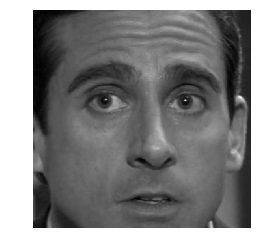

In [5]:
'''Verify that the previous three functions work as intended'''
img_path = 'reference/6-Facial_Recognition/michael/25.png'

# Test our three functions
img = create_img(img_path)
character = associated_character(img_path)
test_img, rect = detect_face(img)

# Show the results
print('Associated Character : {}'.format(character))
_ = plt.axis('off')
_ = plt.imshow(test_img, cmap='gray')

```prepare_data``` uses these three functions to clean our image dataset and present it in a workable form for our project. The function returns three dictionary-type data structures that have keys that correspond to an index associated with the character. For example, Jim is associated with Key 0, Dwight is associated with Key 1, etc. We do this because OpenCV only accepts labels as integer values so we need each character to have a corresponding integer value that OpenCV can interpret. The 3 dictionary-type data structures that this function returns are:

1. ```character_dict``` : A dictionary that allows us to reference the integer labels back to their character's names. 


2. ```face_dict``` : A list ```defaultdict``` of the cropped grayscale face images of each character associated by their character's index. 


3. ```original_dict``` : A list ```defaultdict``` similar to ```face_dict```, but holds the original images instead of the cropped grayscale images.

A useful feature of this function is that it deletes all images where the classifier didn't find a face. This lets us clean the dataset as we prepare the dataset for cross-validation.

In [6]:
'''
    Load the image data from the project directory into the program and delete images that cannot successfully
    locate a face from the image.
    
    Function returns dictionaries indexed by values associated with each character
    
    character_dict : Dictionary to reassociate index to its character
    face_dict : Dictionary that contains all the grayscale face images from the project directory image data
    original_dict: Dictionary that contains all the original project directory image data
    
'''
def prepare_data():
    # Retrieve all the png files containing images of characters' faces
    img_path_list = glob('reference/6-Facial_Recognition/*/*.png')
    
    # character_dict stores label number as key and the character's name as value
    character_list = []
    character_dict = {}
    
    # face_dict stores character label number as key and a list of face images as values
    face_dict = defaultdict(list)
    original_dict = defaultdict(list)
    character_index = 0
    
    for img_path in img_path_list:
        
        img = create_img(img_path)
        character = associated_character(img_path)
        gray, rect = detect_face(img)
        
        # Add the character to the character dictionary if they're not in it yet
        if character not in character_list and character != 'test':
            character_dict[character_index] = character
            character_list.append(character)
            character_index += 1
        
        # Find which index is associated with the character
        for char_index, c in character_dict.items():
            if c == character:
                label = char_index
        
        # Add the image to the character's face image list in face_dict
        if gray is not None:
            
            # Add the original picture to original_dict
            original_dict[label].append(img)
            face_dict[label].append(gray)
        
        # If there's no face detected, remove the img file from the directory
        if gray is None:
            os.remove(img_path)
    
    # Return the dictionary with character names and dictionary with character face images
    return character_dict, face_dict, original_dict

Character Dictionary: {0: 'jim', 1: 'dwight', 2: 'ryan', 3: 'michael'}


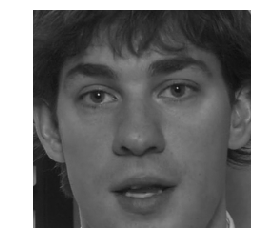

In [7]:
'''Verify that prepare_data() succesfully loads image data from the project directory'''
character_dict, face_dict, original_dict = prepare_data()

example_img = cv2.cvtColor(face_dict[0][0], cv2.COLOR_BGR2RGB)
print('Character Dictionary: {}'.format(character_dict))
_ = plt.axis('off')
_ = plt.imshow(example_img, cmap='gray')

The last preparation function that we have to create before testing the facial recognition model is organizing the list of grayscale face data into a format that the facial recognizer can accept. In order to train the facial recognizer to associate faces to labels, we feed the function two parameters. The first parameter is a list of grayscaled faces that we want to train with. The second parameter is a list of integer labels that each face belongs to. 

From the above ```prepare_data``` function, we created ```face_dict``` that stores a list ```defaultdict``` of all the grayscaled face images associated with that character's label. Getting ```face_dict[0]``` will return a list of all the grayscaled faces for Jim and ```face_dict[0][0]``` returns the first grayscaled face from that list (as shown above).

Our end goal is to iterate through all the lists stored in the ```face_dict``` and create a super-list that stores all these grayscaled faces into a single list. At the same time, we'll also have to add the same number of integer labels to another super-list as the number of faces that we're adding to the face super-list. For example, if there are 10 grayscaled faces of Jim being added to the face super-list, there has to be 10 values of 0 that are added to the label super-list. We can pass these two lists into the facial recognition model for training.

The return of the function will be two lists. 
1. ```all_faces``` : The grayscaled face super-list from the provided face dictionary.


2. ```all_labels``` : The label super-list with same size as ```all_faces``` whose values correspond to the index labels of the grayscaled faces in ```all_faces```. 

You can see how we do that below.

In [8]:
'''
    Because the LBPH Face Recognizer only accepts a list containing grayscale images of faces and a numpy
    array of their corresponding labels, this function takes the face images from face_dict and returns 1-1
    super-lists of the grayscale list of faces and a list of the faces' corresponding labels
'''
def combine_face_label_list(face_dict):
    # all_faces : Super-list of numpy arrays that contains all the grayscale face information in one list
    # all_labels: Numpy super-array that contains all numeric labels associated with each face
    all_faces = []
    all_labels = np.array([])

    # Iterate through each list of faces associated with each character in face_dict
    for label, face_list in face_dict.items():

        # And the face to the all_faces super-list 
        for face in face_list:
            all_faces.append(face)

        # Add the same number of labels as there are faces of associated character to all_labels super-list
        all_labels = np.append(all_labels, np.full(len(face_list), label))
    all_labels = all_labels.astype(int)
    
    return all_faces, all_labels

Associated Image Label: 1
Associated Character: dwight


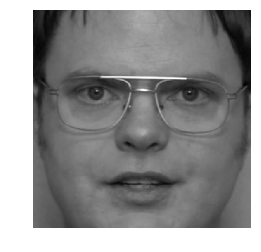

In [9]:
'''Verify that combine_face_label_list worked as intended'''
all_faces, all_labels = combine_face_label_list(face_dict)
test_idx = 30
test_label = all_labels[test_idx]

print('Associated Image Label: {}'.format(test_label))
print('Associated Character: {}'.format(character_dict[test_label]))

_ = plt.axis('off')
_ = plt.imshow(all_faces[test_idx], cmap='gray')

---

## Creating a Custom Predict Function

We can create our predict function now that our data is prepared.

For us to figure out the name of a person from a picture, we first think about times that we've seen that person before we make our guess. We do this in code with OpenCV's ```predict``` function. You provide the predict function with "memories" of people's faces and the image that you're trying to predict on. These "memories" are stored in a facial recognition model that you train with pictures associated to each person in the training set. The ```predict``` method  uses the model to return a label tuple with the predicted face's label and the classifier's confidence that its prediction is correct.

For the LBPH Face Recognizer, the classification task of naming a person's face works similarly to LBPH Face Detection. During the training phase, the LBPH Face Recognizer takes the local binary pattern histograms generated from images associated with the person's face and creates an average feature histogram associated with that person. 

When the LBPH Face Recognizer predicts a name to associate with a face in the picture, it decomposes the face to its own LBPH histogram and compares that histogram to histograms from the training data. The closest matching histogram is then associated to a label with a certain level of confidence that that label is correct.

<figure>
<img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m5-FeatureHistogramFaceImage.jpg" alt="5-Fold CV" class="center">
<figcaption><center><b>Visual Representation of LBPH Face Recognition</b></center></figcaption>
</figure> 


One caveat of facial recognition is that the classifier won't predict names of people that its never seen before. If you ask the classifier to predict a name to a picture of Kevin, but you didn't train the classifier with pictures of Kevin, the classifier will still try to guess with the name of someone that is provided in the training data.

Our custom predict function incorporates OpenCV's predict function and draws a green rectangle and text of the person's name and where the computer found a face in the image. The function then returns this updated image and the predicted character's name.

In [10]:
'''
    Run the prediction on the image and draw a rectangle with the predicted label on a copy of the image
'''
def predict(img, face_recognizer):
    
    # Read the image from the image path
    face, rect = detect_face(img)
    img_copy = img.copy()
    
    # Draw rectangle and predicted character name around face if a face was detected
    if face is not None:
        
        # Set the coordinates for drawing the rectangle around face
        (x, y, w, h) = rect
        
        # Predict what character is shown in the picture
        label = face_recognizer.predict(face)
        
        # Find the name of the character in the character dictionary
        pred_character = character_dict[label[0]]
        
        # Draw predicted character name and rectangle in green if the prediction was right
        green = (0, 255, 0)
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), green, 2)
        cv2.putText(img_copy, pred_character, (x, y-15), 
                    cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=green, thickness=2)
    
    # Draw label that no face was detected if classifier finds no face in picture
    else:
        label = 'No Face Detected'
        red = (0, 0, 255)
        cv2.putText(img_copy, label, (20, 50), 
                    cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(0, 0, 255), thickness=2)
    return img_copy, label[0]

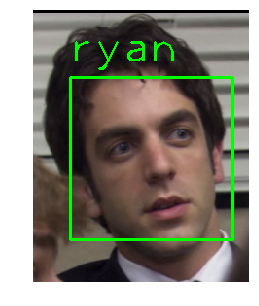

In [11]:
'''Verify that the predict function worked'''

test_img_path = 'reference/6-Facial_Recognition/ryan/12.png'

test_img = create_img(test_img_path)

lbph_recognizer = cv2.face.LBPHFaceRecognizer_create()
lbph_recognizer.train(all_faces, all_labels)

pred_img, _ = predict(test_img, lbph_recognizer)

pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
_ = plt.figure(figsize=(4, 5))
_ = plt.axis('off')
_ = plt.imshow(pred_img, aspect='equal')

---

## Preparing Utility Functions for Cross Validation

Now that we've created a functional ```predict``` function for our project, the next step we need to work on is cross-validating our model.

Cross-validation is the act of taking the data we have and splitting it into discrete folds (5 folds being common practice). After splitting our data into the desired number of folds, we use all but 1 fold as training folds and the last fold as a prediction fold for our classifier.

For the prediction fold that we use to validate our model, we know what the actual labels are supposed to be. We can compare the actual labels and predicted labels to gather metrics on the classifier's performance from the generated confusion matrix (which I'll explain later).

Now, since we separated the data into 5 folds, we can perform this test again where one of the other folds is the prediction fold and the remaining folds are the training folds. Doing so will generate another confusion matrix which we can use to create another set of metrics to validate our model's performance on. In fact, we can repeat this process the same number of times we folded on and gather that many performance metrics for the model. Taking the average of this value will provide a closer estimate on the true performance of the classifier over running the classifier on a single training and prediction set.

<figure>
<img src="https://miro.medium.com/max/2736/1*rgba1BIOUys7wQcXcL4U5A.png" alt="5-Fold CV" class="center" style="width:449px;height:300px;">
<figcaption><center><b>Visual Representation of 5-Fold Cross Validation</b></center></figcaption>
</figure> 

For this project, we create three utility functions prior to cross-validating our classifier's performance. 

The first function is ```shuffle_face_original```. What this function does is that it takes the grayscaled face images from ```face_dict``` and the original images from ```original_dict``` and shuffles the pictures while coordinating their positions in their respective lists. For example, if the first grayscaled face of Jim becomes the fifth grayscaled face in the list after the shuffle, we want the first original picture of Jim (which the grayscaled face corresponds to) to also be the fifth original picture in its list.

The reason why shuffling is useful for cross-validation is because it randomizes the images that the model trains and predicts on. If we don't shuffle the order of the grayscaled and original images, then we can only get one value from cross-validation since the training and prediction sets will always be the same. 

If we want to make our shuffle reproducible, the function accepts an optional ```random_state``` variable that sets a seed at the start of the function call so the images shuffle the same way each time.

```shuffle_face_original``` returns ```working_face_dict``` and ```working_original_dict``` which are shuffled copies of the provided grayscaled faces and original image dictionaries.

In [12]:
'''
    When running cross-validation tests, it's useful to shuffle the order of the items in the train-test data
    to gather more information about the validity of the model when running multiple cross-validation tests.
    
    This function returns a shuffle of the grayscale face images and the original images from their corresponding
    dictionaries.
'''

def shuffle_face_original(face_dict, original_dict, random_state=None):

    np.random.seed(random_state)
    working_face_dict = defaultdict(list)
    working_original_dict = defaultdict(list)

    for (character_idx, face_list), (_, original_list) in zip(face_dict.items(), original_dict.items()):
        indices = np.arange(len(face_list))
        np.random.shuffle(indices)
        working_face_dict[character_idx] = [face_list[i] for i in indices]
        working_original_dict[character_idx] = [original_list[i] for i in indices]
    
    return working_face_dict, working_original_dict

The second and third utility functions we'll use for cross-validation are called ```predict_generate_confusion_matrix``` and ```generate_f1_scores```.

As I mentioned before, when we predict the label associated to an image, we'll want to compare the predicted labels to the actual labels in the form of a confusion matrix.

The confusion matrices we'll generate in ```predict_generate_confusion_matrix``` are organized by predictions on rows and actual labels on columns. Each row and column corresponds to a character from our character dictionary. When we make a prediction, we increment the value of (predicted character, actual character) in our matrix by 1. For example, if we predict a picture is Dwight but it's actually a picture of Ryan, we look at the cell in (Dwight, Ryan) and increment the cell by 1. We can use this confusion matrix to generate a metric known as the F1 score.

F1 score is a combined metric of the classifier's precision and recall. <b>Precision is defined by how well a model was able to correctly guess a label based on how many times it guessed that label.</b> So for the example below, the model predicted Dwight 9 times (the sum of all the values in the Dwight prediction row) and the number of times it got this prediction right was 7. So the model's precision for Dwight is ${7\over9} = 78\%$.

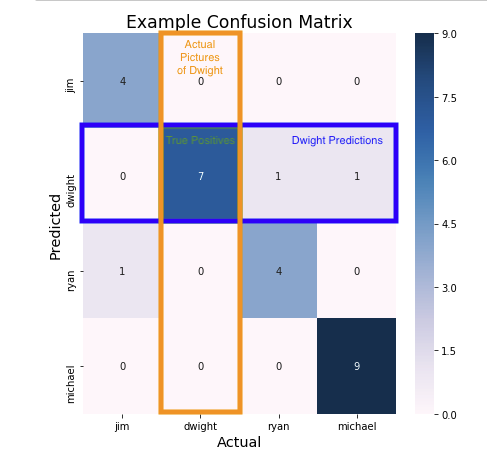

<b>Recall is the model's ability to correctly identify pictures of a given label based on how many pictures actually have that label.</b> For the same example, the model actually has 7 pictures of Dwight (which is the sum of the Dwight actual column) and predicted on 7 pictures of Dwight. This means that the classifier's recall for Dwight was ${7\over7}=100\%$. The classifier was able to find all the pictures of Dwight from the batch.

<b>The F1 score is the harmonic mean between precision and recall.</b> To calculate the final F1 score, you combine precision and recall by $${2* precision*recall}\over{precision+recall}$$ which is $F1 = {2*0.78*1\over0.78+1} = 88\%$ for Dwight in this example.

Our ```generate_f1_scores``` function takes the confusion matrix and generates F1 scores for each character. These F1 scores are returned in the form of a list called ```f1_score_list```.

In [13]:
'''
    The confusion matrix can be used to generate f1-scores to gauge the validity of a given model
    
    This function takes in a dictionary of test images indexed by the character indexes and returns
    a list of images with rectangle and the prediction drawn, as well as a confusion matrix to find 
    classification metrics
'''

def predict_generate_confusion_matrix(test_dict, character_dict, face_recognizer, pred_face_list):
    
    # Generate initial confusion matrix DataFrame
    character_list = []
    for _, character in character_dict.items():
        character_list.append(character)
    data = np.zeros((len(character_list), len(character_list)), dtype=int)
    confusion_matrix = pd.DataFrame(data=data, index=character_list, columns=character_list)
    
    # Make predictions on the test images and add to DataFrame
    for true_label, test_face_list in test_dict.items():
        for test_face in test_face_list:
            
            # Make prediction on test image and add to pred_face_list
            pred_face, pred_label = predict(test_face, face_recognizer)
            pred_face_list.append(pred_face)
            
            # Populate confusion matrix based on prediction
            actual_character = character_dict[true_label]
            pred_character = character_dict[pred_label]
            confusion_matrix.loc[pred_character, actual_character] += 1
    
    return pred_face_list, confusion_matrix

In [14]:
'''
    F1 score is the harmonic mean between precision and recall which tidily summarizes the combination
    of the two metrics in lieu of the classifier model
    
    This function takes the confusion matrix and the dictionary of characters and returns a list of F1 scores
    associated with each character.
'''

def generate_f1_scores(confusion_matrix, character_dict):
    f1_score_list = []
    for _, character in character_dict.items():
        true_positive = confusion_matrix.loc[character, character]
        if true_positive == 0:
            precision = 0
            recall = 0
            f1 = 0
        else:
            precision = true_positive / confusion_matrix.sum(axis=1)[character]
            recall = true_positive / confusion_matrix.sum(axis=0)[character]
            f1 = 2 * (precision*recall) / (precision + recall)
        f1_score_list.append(f1)
    return f1_score_list

---

## Cross-Validating the Naive Facial Recognition Classifier

Now that we have our utility functions prepared, we can finally cross-validate our naive LBPH Facial Recognizer model to see how well it performs with our given data.

We begin our cross-validation by first shuffling the order of the grayscaled face and original image dictionaries with an optional ```random_state``` variable in case we want to reproduce the same shuffle. Then, we create testing and training dictionaries that are organized by the characters' corresponding labels. <b>The number of testing images we have in our testing dictionary for each character is ${1\over folds} * Images $ for each character.</b> For example, if we're using 5-fold cross-validation and have 10 images for Jim and 20 images for Michael, then we'll want to add 2 images for Jim (1/5th the number of images for Jim) and 4 images for Michael (1/5th the number of images for Michael) to the testing dictionary and train on the rest of the images. Splitting the images on a per-character basis ensures that the classifier will be trained on images from each character in the dataset.

Now that we've shuffled and split our data into training and testing sets, we then prepare our training data from dictionary form into a grayscale face list and a labels list and feed it to the facial recognizer's ```train``` function. As mentioned before, the ```train``` function for the LBPH Facial Recognizer decomposes the features from each training image into characteristic histograms associated with each character. 

Using the trained classifier, we then predict on the testing data and create a confusion matrix to compare the classifier's predictions to the actual image's labels. The confusion matrix can then be used to generate F1 scores for each character which are averaged out to provide an average F1 score across all characters in the dataset. We store our graphical predictions in ```pred_face_list``` and the average F1 scores from the confusion matrix in ```f1_average_list```. 

Repeating this process folds number of times yields folds number of F1 averages in ```f1_average_list```. The final metric to judge performance on is ```average_f1``` which takes all the values from ```f1_average_list``` and averages them out. The function returns ```average_f1```, ```f1_average_list```, ```pred_face_list```, and ```confusion_matrix_list```.

In [15]:
def cross_validate(face_dict, original_dict, face_recognizer, folds=5, random_state=None):
            
    # train_dict : training dictionary with key = character_idx and value = character img
    # test_dict : test dictionary with key = character_idx and value = character img
    train_dict = defaultdict(list)
    test_dict = defaultdict(list)
    
    # pred_face_list : Keeps track of all the faces the classifier predicts
    # f1_average_list : Keeps track of f1 scores for each fold
    pred_face_list = []
    f1_average_list = []
    confusion_matrix_list = []
    
    # Shuffle the grayscale image face list and original images
    cv_face_dict, cv_original_dict = shuffle_face_original(face_dict, original_dict, random_state)
    
    for i in range(folds):

        for (character_idx, face_list), (_, original_list) in zip(cv_face_dict.items(), cv_original_dict.items()):

            # Train-test split the grayscale and original images for each character based on number of folds
            test_sample_len = int( 1/folds * len(face_list) )
            test_dict[character_idx] = original_list[i*test_sample_len : (i+1)*test_sample_len]
            train_dict[character_idx] = face_list[ : i*test_sample_len] + face_list[(i+1)*test_sample_len :]

        # Create face and label lists from training data for the classifier
        train_faces, train_labels = combine_face_label_list(train_dict)

        # Train provided model using the training data
        face_recognizer.train(train_faces, train_labels)

        # Generate the confusion matrix by predicting test images
        pred_face_list, confusion_matrix = predict_generate_confusion_matrix(test_dict, character_dict,
                                                                            face_recognizer, pred_face_list)
        confusion_matrix_list.append(confusion_matrix)
        
        # Gather f1 score information from data gathered in testing phase
        f1_score_list = generate_f1_scores(confusion_matrix, character_dict)
        f1_average_list.append(round(np.mean(f1_score_list), 2))
        
    # Average the f1 scores together
    average_f1 = round(np.mean(f1_average_list), 2)
    
    return pred_face_list, average_f1, f1_average_list, confusion_matrix_list

---

## Testing the Project Images

Putting everything together and running ```cross_validate``` on the images stored in our project directory produces the following.

In [16]:
face_recognizer = cv2.face.LBPHFaceRecognizer_create()
pred_face_list, average_f1, f1_average_list, confusion_matrix_list = cross_validate(face_dict, original_dict,
                                                                                    face_recognizer, folds=5,
                                                                                    random_state=42)

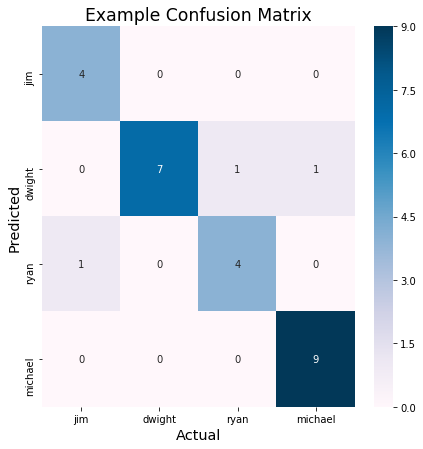

In [17]:
_ = plt.figure(figsize=(7, 7))
_ = sns.heatmap(confusion_matrix_list[0], annot=True, cmap='PuBu')
_ = plt.title('Example Confusion Matrix', fontsize='xx-large')
_ = plt.xlabel('Actual', fontsize='x-large')
_ = plt.ylabel('Predicted', fontsize='x-large')

In [18]:
print("F1 Average List from 5-Fold CV : {}".format(f1_average_list))

F1 Average List from 5-Fold CV : [0.88, 0.75, 0.76, 0.84, 0.69]


In [19]:
print("Average F1 Score from 5-Fold CV: {}".format(average_f1))

Average F1 Score from 5-Fold CV: 0.78


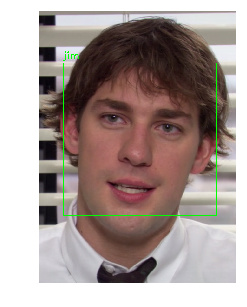

In [20]:
pred_img = pred_face_list[0]
example_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

_ = plt.figure(figsize=(4, 5))
_ = plt.axis('off')
_ = plt.imshow(example_img)

---

## Further Validation

After running our LBPH Classifier once, we can see that the classifier's average F1 score was 78%. That's a good start, but this is just one average F1 score from a single 5-fold cross-validation test. It's possible to get a better picture of our model's performance by running the 5-fold cross-validation test again and seeing how it performs with a different train-test split.

As I mentioned before, the ```random_state``` variable creates a reproducible shuffle on all the images before running the train-test split. What we can do is create a list of 100 ```random_state``` variables using ```np.random.randint```. Then, we can iterate through each value of the random integer list (which we reference as ```rand_num_list``` for this example) and perform 5-fold cross-validation 100 times to score out 100 average F1 scores.

The <b>Central Limit Therorem</b> states that the distribution of a measured statistic over a given population across multiple random samples should be roughly normal with enough random samples. 100 random train-test split shuffles should exhibit this behavior. By performing 5-fold cross-validation 100 times on the image set that we have, we should have a better understanding of the true facial recognition F1 score distribution from the naive LBPH Facial Recognizer classifier.


The below example runs through the process of gathering the F1-Score distribution. 

In [21]:
np.random.seed(42)
cv_repeat = 100
rand_num_list = np.random.randint(cv_repeat, size=cv_repeat)

total_f1_list = []
for random_state in rand_num_list:
    _, average_f1, _, _ = cross_validate(face_dict, original_dict, face_recognizer, 
                                         folds=5, random_state=random_state)
    total_f1_list.append(average_f1)

In [22]:
mean = np.mean(total_f1_list)
intervals = np.percentile(total_f1_list, [2.5, 97.5])

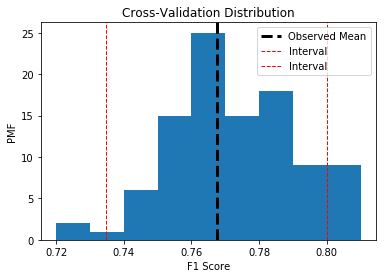

Lower Interval F1 Score = 0.73
Upper Interval F1 Score = 0.80
Observed Average F1 Score = 0.77


In [23]:
# Plot the generated points as a histogram with markers indicating confidence interval and mean
bins = 9
_ = plt.hist(total_f1_list, bins=bins, density=True)
_ = plt.axvline(mean, color='black', linestyle='dashed', linewidth=3)
_ = plt.axvline(intervals[0], color='red', linestyle='dashed', linewidth=1)
_ = plt.axvline(intervals[1], color='red', linestyle='dashed', linewidth=1)

# Display the distribution
_ = plt.xlabel('F1 Score')
_ = plt.ylabel('PMF')
_ = plt.title('Cross-Validation Distribution')
_ = plt.legend(('Observed Mean', 'Interval', 'Interval'), loc='upper right')
plt.show()

# Print summary statistics
print('Lower Interval F1 Score = {:.2f}'.format(intervals[0]))
print('Upper Interval F1 Score = {:.2f}'.format(intervals[1]))
print('Observed Average F1 Score = {:.2f}'.format(mean))

After running 100 5-fold cross-validation tests, we find that the average F1 score is 77% with a 95% confidence interval that the true F1 score is between 73-80%. Our goal now is to improve the average F1 score of the naive LBPH Face Recognizer classifier.

In the next blog post, we'll discuss hyperparameter tuning to accomplish this goal. From there, we'll run the classifier on the season one footage of <i>The Office</i> and work on gathering screentimes for each character. We're getting close to the end of the project! Until next time, cheers :)